# Time Series Test Plan Demo

In [1]:
# Quick hack to load local SDK code

import os

os.chdir(os.path.join(os.getcwd(), "../.."))

# Load API key and secret from environment variables
from dotenv import load_dotenv
load_dotenv()


True

In [2]:

import validmind as vm
vm.init(  api_host = "http://localhost:3000/api/v1/tracking",
  api_key = "e22b89a6b9c2a27da47cb0a09febc001",
  api_secret = "a61be901b5596e3c528d94231e4a3c504ef0bb803d16815f8dfd6857fac03e57",
  project = "clgmfxwvp0000k8rlc997oe9t")


True

In [3]:
# System libraries
import glob

# ML libraries
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from arch.unitroot import PhillipsPerron, DFGLS
import xgboost as xgb
from numpy import argmax
from sklearn.metrics import accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split

# Plotting libraries 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
def merge_fred_csv_files(file_pattern):
    # Use glob to find all files matching the specified pattern
    file_list = glob.glob(file_pattern)

    # Initialize an empty list to store individual DataFrames
    dataframes = []

    # Iterate through each file in the file list
    for file in file_list:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file, parse_dates=['DATE'], index_col='DATE')

        # Add the DataFrame to the list of DataFrames
        dataframes.append(df)

    # Merge all the DataFrames in the list into a single DataFrame
    merged_df = pd.concat(dataframes, axis=1)

    return merged_df


file_pattern = './notebooks/datasets/fred/*.csv'
df = merge_fred_csv_files(file_pattern)
display(df)

,GDPC1,GS5,GS10,GS3,MORTGAGE30US,UNRATE,CPIAUCSL,FEDFUNDS,GDP
DATE,,,,,,,,,
1947-01-01,2034.450,NaN,NaN,NaN,NaN,NaN,21.48,NaN,243.164
1947-02-01,NaN,NaN,NaN,NaN,NaN,NaN,21.62,NaN,NaN
1947-03-01,NaN,NaN,NaN,NaN,NaN,NaN,22.00,NaN,NaN
1947-04-01,2029.024,NaN,NaN,NaN,NaN,NaN,22.00,NaN,245.968
1947-05-01,NaN,NaN,NaN,NaN,NaN,NaN,21.95,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2023-04-01,NaN,NaN,3.46,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-06,NaN,NaN,NaN,NaN,6.28,NaN,NaN,NaN,NaN
2023-04-13,NaN,NaN,NaN,NaN,6.27,NaN,NaN,NaN,NaN


In [5]:
selected_cols = ['MORTGAGE30US', 'UNRATE', 'GS10', 'FEDFUNDS'] 
df = df[selected_cols]

In [6]:
def plot_time_series(df, cols_to_plot=None, title=''):
    """
    Plot multiple time-series in the same axes using seaborn.

    :param df: DataFrame with time-series data
    :param cols_to_plot: List of column names to plot. If None, plot all columns in df.
    :param title: Title of the plot, default is ''
    """
    if cols_to_plot is None:
        cols_to_plot = df.columns.tolist()

    # Create a new DataFrame with the columns to plot
    plot_df = df[cols_to_plot]

    # Set seaborn plot style
    sns.set(style="darkgrid")

    # Plot the time-series data
    plt.figure(figsize=(12, 6))
    for col in plot_df.columns:
        sns.lineplot(data=plot_df[col], label=col)

    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.show()


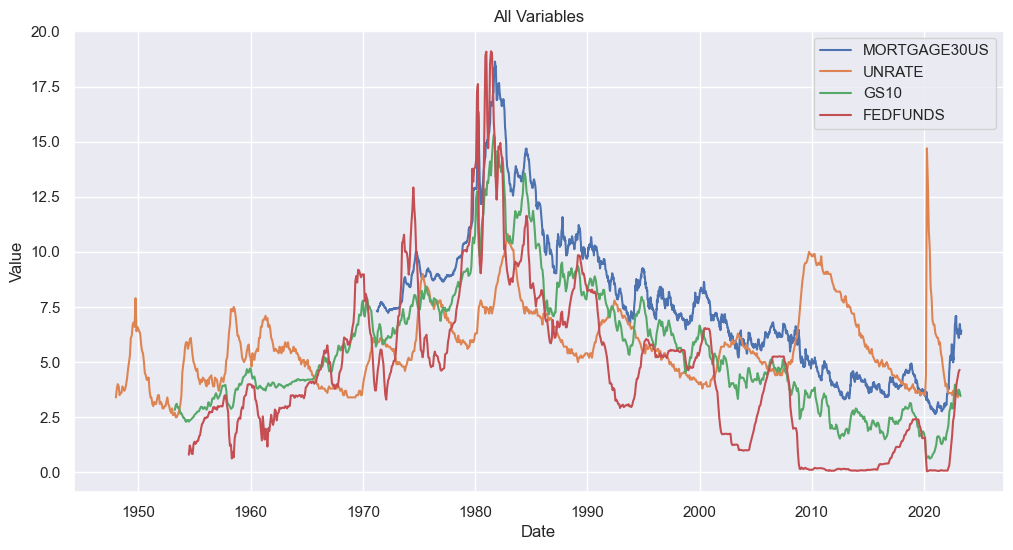

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3551 entries, 1947-01-01 to 2023-04-27
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MORTGAGE30US  2718 non-null   float64
 1   UNRATE        903 non-null    float64
 2   GS10          841 non-null    float64
 3   FEDFUNDS      825 non-null    float64
dtypes: float64(4)
memory usage: 138.7 KB


In [7]:
plot_time_series(df, title='All Variables')
df.info()

In [8]:
def plot_time_difference_frequency(df):
    # Calculate the time differences between consecutive entries
    time_diff = df.index.to_series().diff().dropna()

    # Convert the time differences to a suitable unit (e.g., days)
    time_diff_days = time_diff.dt.total_seconds() / (60 * 60 * 24)

    # Create a DataFrame with the time differences
    time_diff_df = pd.DataFrame({'Time Differences (Days)': time_diff_days})

    # Plot the frequency distribution of the time differences
    sns.histplot(data=time_diff_df, x='Time Differences (Days)', bins=50, kde=False)
    plt.xlabel('Time Differences (Days)')
    plt.ylabel('Frequency')
    plt.show()

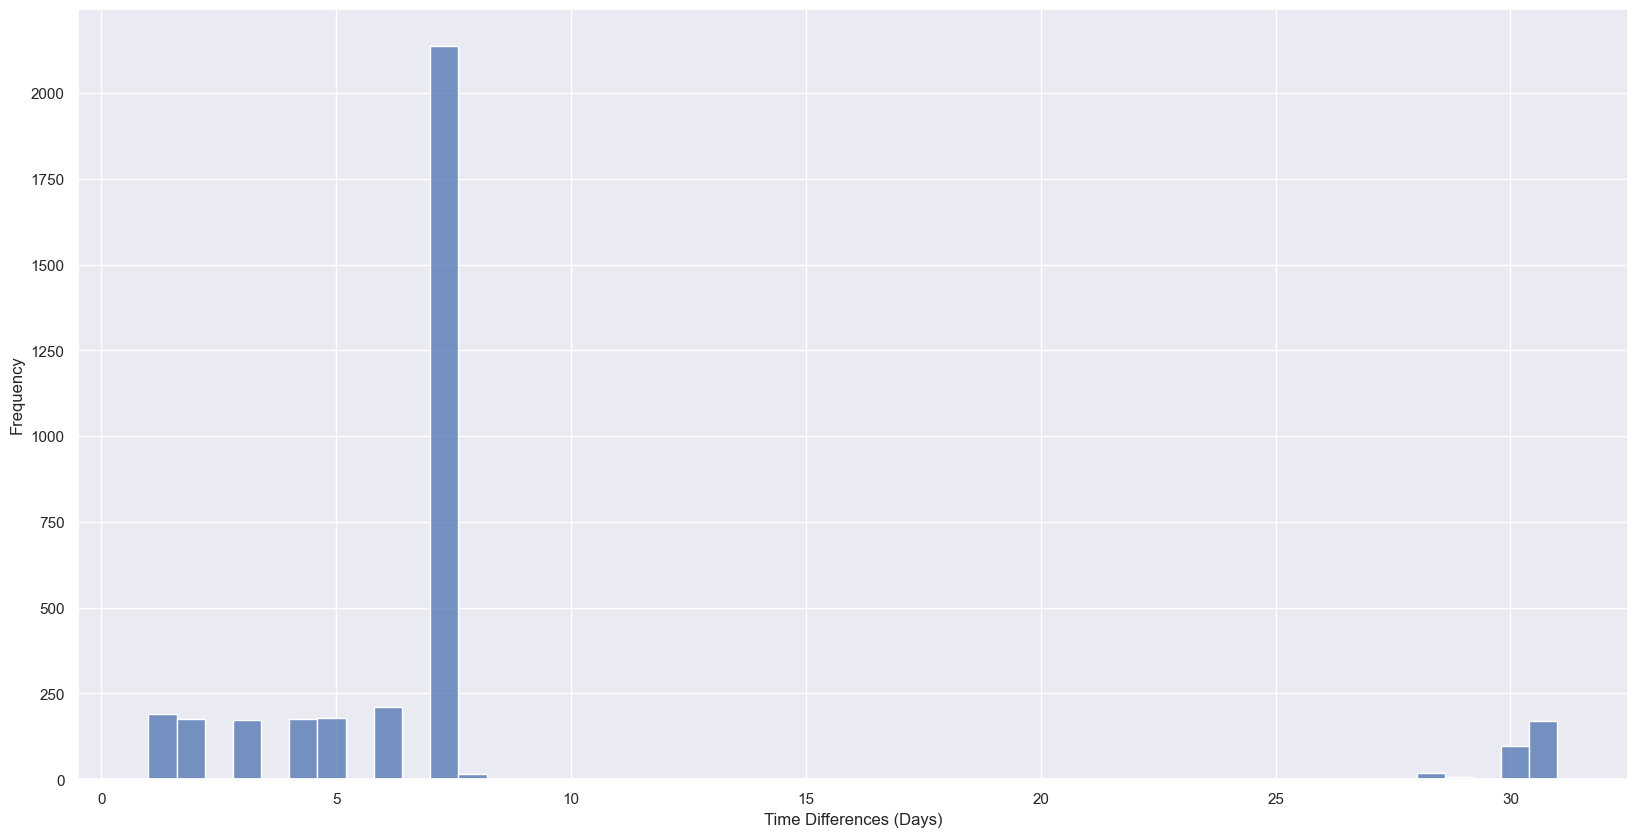

In [9]:
plot_time_difference_frequency(df)

In [10]:
def identify_frequencies(df):
    """
    Identify the frequency of each series in the DataFrame.

    :param df: Time-series DataFrame
    :return: DataFrame with two columns: 'Variable' and 'Frequency'
    """
    frequencies = []
    for column in df.columns:
        series = df[column].dropna()
        if not series.empty:
            freq = pd.infer_freq(series.index)
            if freq == 'MS' or freq == 'M':
                label = 'Monthly'
            elif freq == 'Q':
                label = 'Quarterly'
            elif freq == 'A':
                label = 'Yearly'
            else:
                label = freq
        else:
            label = None

        frequencies.append({'Variable': column, 'Frequency': label})

    freq_df = pd.DataFrame(frequencies)

    return freq_df

In [11]:
frequencies = identify_frequencies(df)
display(frequencies)

,Variable,Frequency
0,MORTGAGE30US,None
1,UNRATE,Monthly
2,GS10,Monthly
3,FEDFUNDS,Monthly


In [12]:
df = df.resample('MS').last()
frequencies = identify_frequencies(df)
display(frequencies)

,Variable,Frequency
0,MORTGAGE30US,Monthly
1,UNRATE,Monthly
2,GS10,Monthly
3,FEDFUNDS,Monthly


In [13]:
def plot_missing_values_bar(df):
    """
    Plot a bar chart displaying the total number of missing values per variable (column) in a time-series DataFrame using seaborn.
    
    :param df: Time-series DataFrame
    """
    # Calculate the total number of missing values per column
    missing_values = df.isnull().sum()

    # Set seaborn plot style
    sns.set(style="darkgrid")

    # Plot the bar chart
    plt.figure(figsize=(12, 6))
    sns.barplot(x=missing_values.index, y=missing_values.values)
    
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Variables (Columns)')
    plt.ylabel('Number of Missing Values')
    plt.title('Total Number of Missing Values per Variable')
    plt.show()

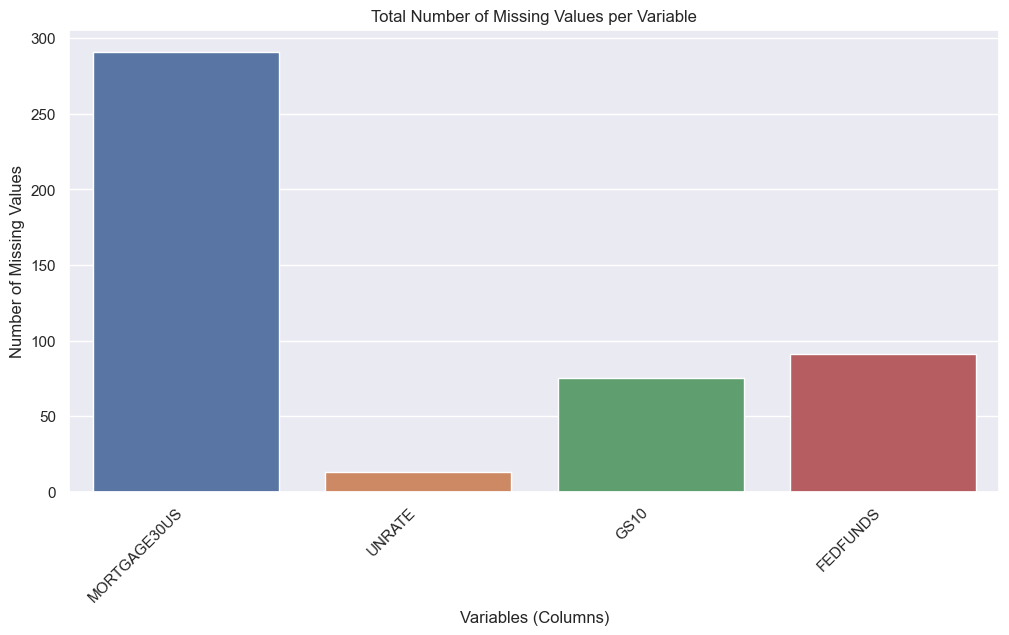

In [14]:
plot_missing_values_bar(df)

In [15]:
def plot_missing_values_heatmap(df, start_year=None, end_year=None):
    """
    Plot a heatmap of missing values with actual years in rows using seaborn.

    :param df: Time-series DataFrame
    :param start_year: Start year for zooming in, defaults to None
    :param end_year: End year for zooming in, defaults to None
    """
    # Filter the DataFrame based on the specified start_year and end_year
    if start_year:
        df = df[df.index.year >= start_year]
    if end_year:
        df = df[df.index.year <= end_year]

    # Create a boolean mask for missing values
    missing_mask = df.isnull()

    # Set seaborn plot style
    sns.set(style="darkgrid")

    # Plot the heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(missing_mask.T, cmap='viridis', cbar=False, xticklabels=False)

    # Add actual years on the x-axis
    years = df.index.year.unique()
    xticks = [df.index.get_loc(df.index[df.index.year == year][0]) for year in years]
    plt.xticks(xticks, years, rotation=45, ha='right')

    plt.ylabel('Columns')
    plt.xlabel('Rows (Years)')
    plt.title('Missing Values Heatmap with Actual Years in Rows')
    plt.show()

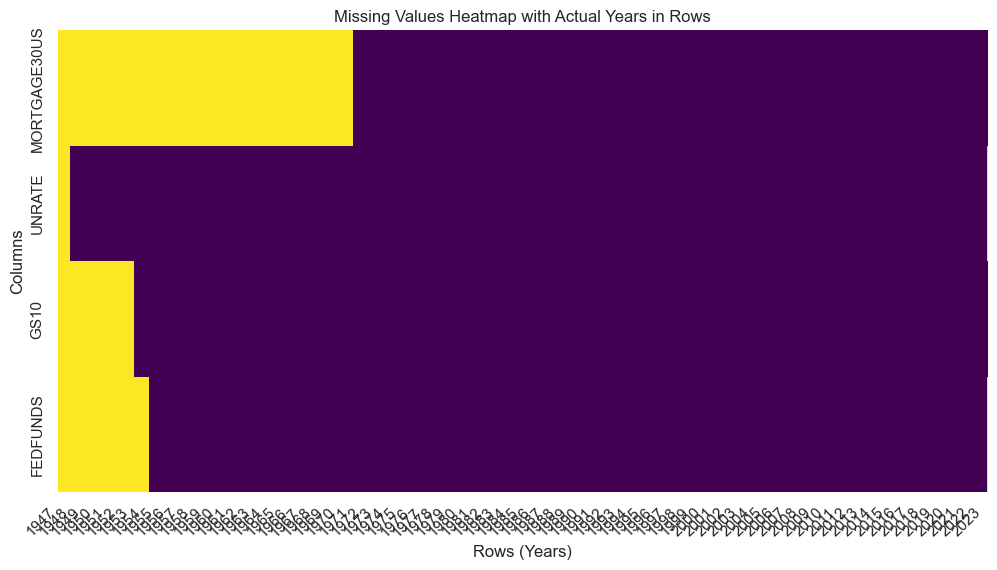

In [16]:
plot_missing_values_heatmap(df)

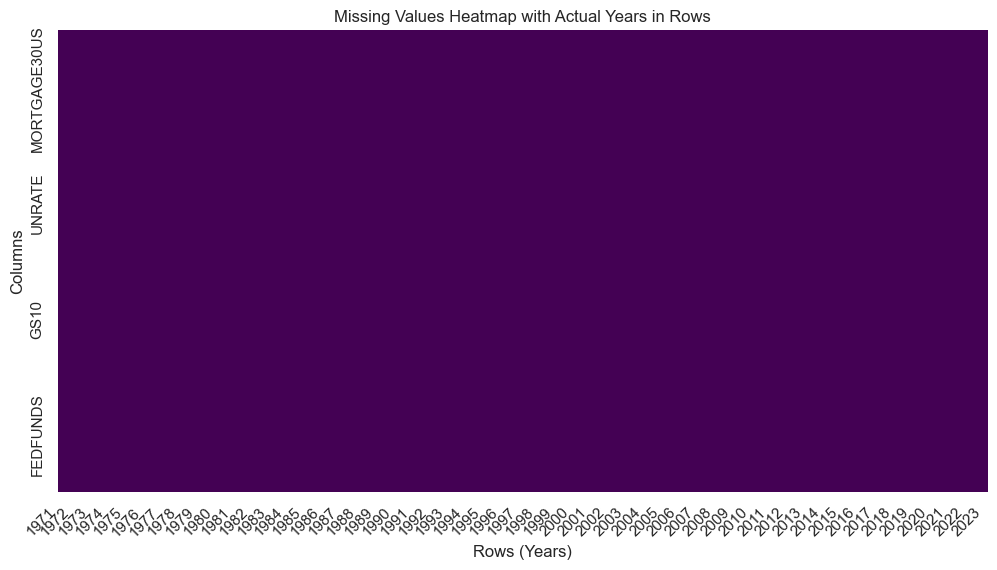

In [17]:
df = df.dropna()
plot_missing_values_heatmap(df)


In [18]:
vm_dataset = vm.init_dataset(
    dataset=df,
    target_column="MORTGAGE30US"
)

Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...


In [19]:
vm.test_plans.list_plans()


ID,Name,Description
sklearn_classifier_metrics,SKLearnClassifierMetrics,Test plan for sklearn classifier metrics
sklearn_classifier_validation,SKLearnClassifierPerformance,Test plan for sklearn classifier models
sklearn_classifier_model_diagnosis,SKLearnClassifierDiagnosis,Test plan for sklearn classifier model diagnosis tests
sklearn_classifier,SKLearnClassifier,Test plan for sklearn classifier models that includes both metrics and validation tests
tabular_dataset,TabularDataset,Test plan for generic tabular datasets
tabular_dataset_description,TabularDatasetDescription,Test plan to extract metadata and descriptive statistics from a tabular dataset
tabular_data_quality,TabularDataQuality,Test plan for data quality on tabular datasets
normality_test_plan,NormalityTestPlan,Test plan to perform normality tests.
autocorrelation_test_plan,AutocorrelationTestPlan,Test plan to perform autocorrelation tests.
seasonality_test_plan,SesonalityTestPlan,Test plan to perform seasonality tests.


In [20]:
vm.test_plans.describe_plan("tabular_dataset")

Attribute,Value
ID,tabular_dataset
Name,TabularDataset
Description,Test plan for generic tabular datasets
Required Context,['dataset']
Tests,
Test Plans,['tabular_data_quality']



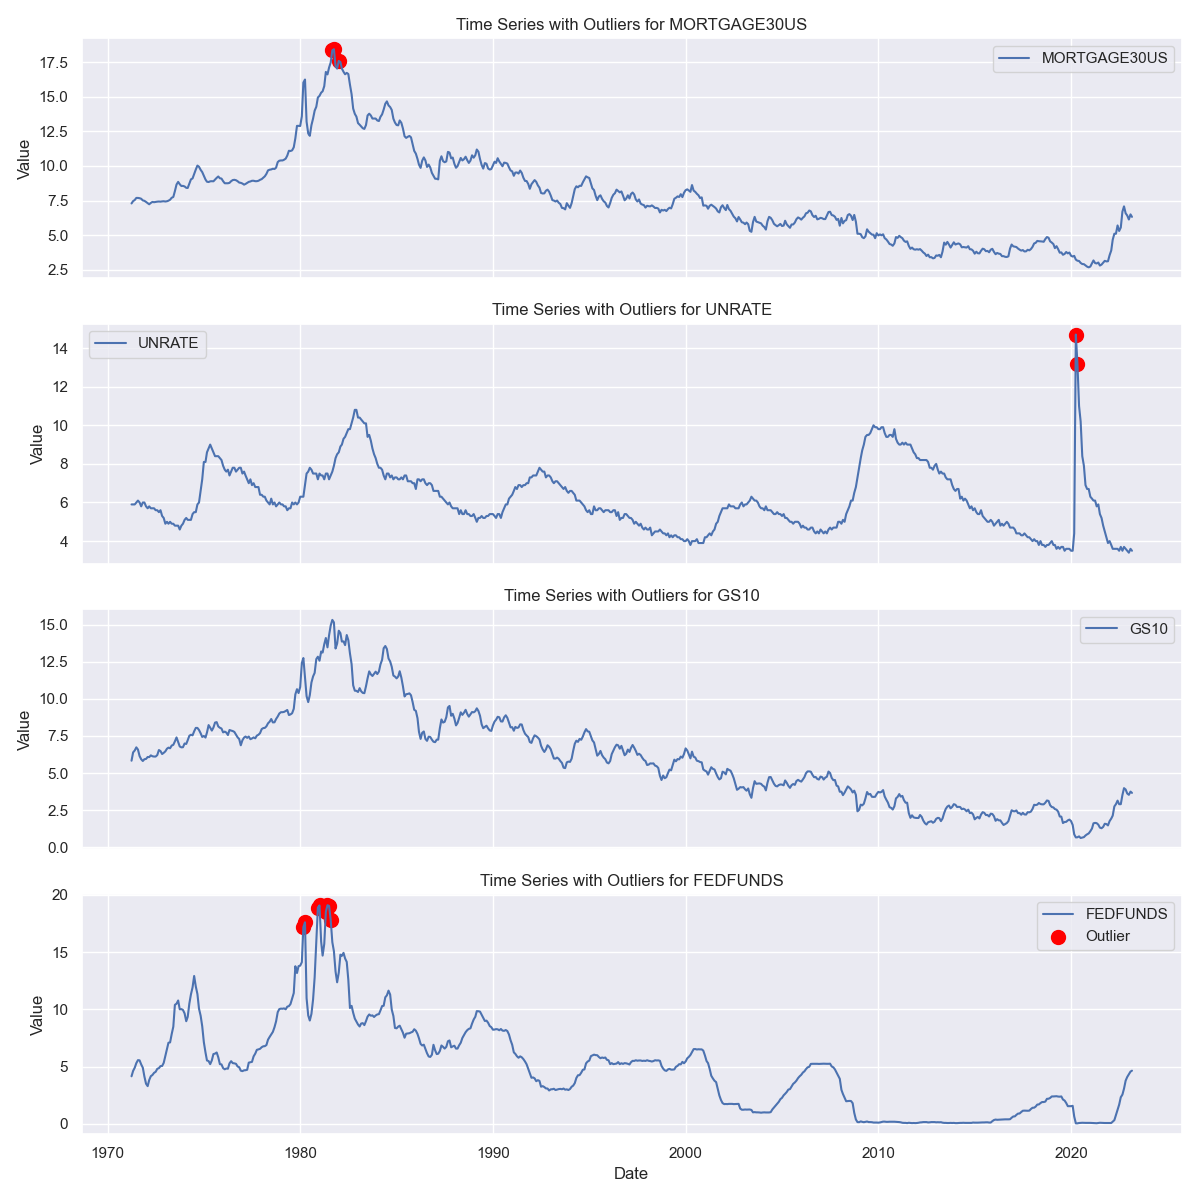

In [21]:
plan = vm.run_test_plan("tabular_dataset", dataset=vm_dataset)